## Model median cost/watt as function of three features: time (days), size_group, state

### First, include one-hot encoded categorical in polynomial expansion.  The coding is simpler but it's very slow because of very-expensive polynomial expansion of one-hot encoded variable state (19 states).

### Summary of results

$R^2$ 

###  transform the data

Compute the median of cost/watt, grouped by time, size_group and state.

In [2]:
import datetime

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [4]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [23]:
# lodd up
dfMod = pd.read_csv('../local/data/LBNL_openpv_tts_data/model_data_2.csv',
                    encoding='iso-8859-1', # avoids windows encoding issue
                    index_col='row_id',
                    parse_dates=['install_date'])

In [24]:
dfMod.head()

,num_days,num_weeks,num_months,size_kw,scaleSize,state,cost_per_watt,install_date
row_id,,,,,,,,
1,0.0,0.0,0.0,2.2824,0.0,CA,10.734315,1998-01-09
2,21.0,3.0,0.0,1.8504,0.0,CA,11.108701,1998-01-30
4,26.0,4.0,1.0,2.3076,0.0,CA,8.667013,1998-02-04
6,84.0,12.0,3.0,2.3316,0.0,CA,13.270286,1998-04-03
7,111.0,16.0,3.0,0.9300,0.0,CA,14.654839,1998-04-30


### Check that I can pull month and year from install date

In [109]:
Epoch = dfMod.iloc[0]['install_date']; Epoch

Timestamp('1998-01-09 00:00:00')

In [113]:
Epoch.year, Epoch.month, Epoch.day

(1998, 1, 9)

### Now that we have three variables, visualization require a little more ingenuity.  See ../story/tts_story_01.ipynb for graphical representation.

### Model with median of each day's data.

Get the median for each state before modeling. Group, take the median over day, size and state.  Then reshape and encode for modeling.

In [45]:
MedByDay = dfMod.groupby(['num_days', 'scaleSize', 'state'])['cost_per_watt'].median()

In [46]:
### take a look
MedByDay.head()

num_days  scaleSize  state
0.0       0.0        CA       10.734315
21.0      0.0        CA       11.108701
26.0      0.0        CA        8.667013
84.0      0.0        CA       13.270286
111.0     0.0        CA       14.654839
Name: cost_per_watt, dtype: float64

In [47]:
thing = MedByDay.reset_index(); thing.head()

,num_days,scaleSize,state,cost_per_watt
0,0.0,0.0,CA,10.734315
1,21.0,0.0,CA,11.108701
2,26.0,0.0,CA,8.667013
3,84.0,0.0,CA,13.270286
4,111.0,0.0,CA,14.654839


In [49]:
dfMedByDay = thing

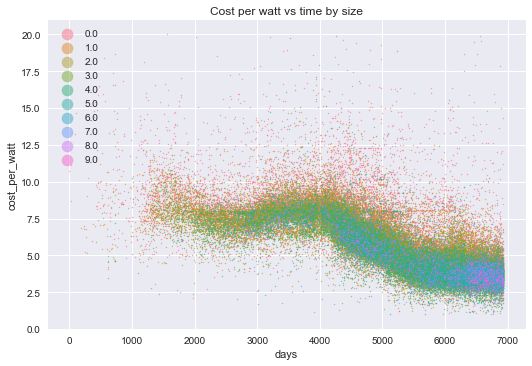

In [59]:
g = sns.FacetGrid(dfMedByDay, hue='scaleSize', size=5, aspect=1.5)
g.map(plt.scatter, 'num_days', 'cost_per_watt', s=5, marker='.', alpha=0.5)
g.ax.set(xlabel='days',
         ylabel='cost_per_watt',
         title='Cost per watt vs time by size')
g.ax.legend(markerscale=10);

In [63]:
dfMedByDay.state.value_counts()[:5]

CA    22466
AZ    10370
NY     8235
MA     7308
TX     5953
Name: state, dtype: int64

### Quick graph of cost vs. time in five biggest states, by size

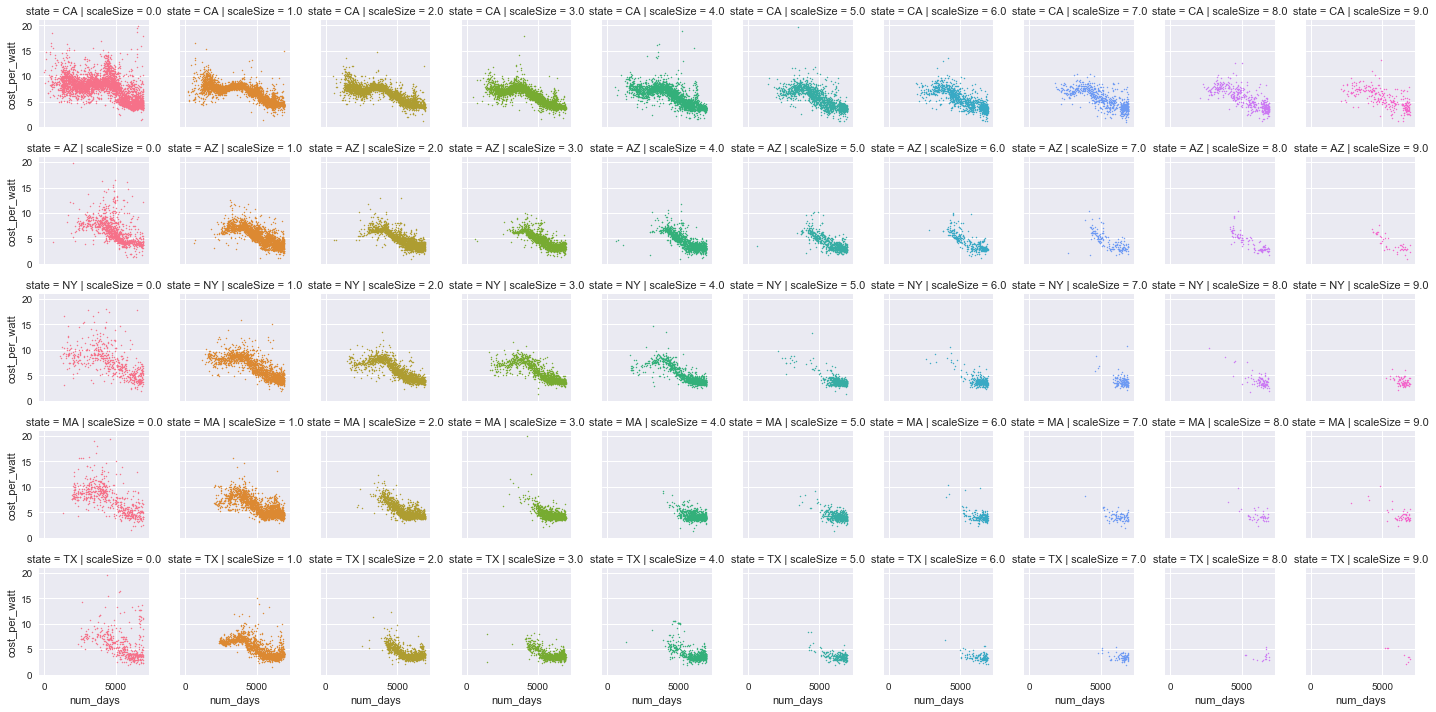

In [70]:
g = sns.FacetGrid(dfMedByDay[dfMedByDay.state.isin(['CA', 'AZ', 'NY', 'MA', 'TX'])], 
                  col='scaleSize', row='state', hue='scaleSize', size=2)
g.map(plt.scatter, 'num_days', 'cost_per_watt', marker='.', s=5);

---

### Encode and get the right shapes

In [72]:
dfModDay = pd.get_dummies(dfMedByDay, drop_first=True); dfModDay.head()

,num_days,scaleSize,cost_per_watt,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
0,0.0,0.0,10.734315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21.0,0.0,11.108701,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,26.0,0.0,8.667013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,84.0,0.0,13.270286,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,111.0,0.0,14.654839,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model median by day, size and state

In [76]:
X = dfModDay.drop(['cost_per_watt'], axis='columns').values
y = dfModDay[['cost_per_watt']].values

X.shape, y.shape

((81293, 20), (81293, 1))

In [79]:
X[0,:]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [77]:
# Setup the pipeline steps
steps = [('scaler', StandardScaler()),
         ('poly', PolynomialFeatures()),
         ('LR', LinearRegression())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

## This is prohibitively expensive to run.  ~60 min

__Undoubtedly, this is due to the very large number of coefficients when including the state one-hot encoded variable in the polynomial expansion__

In [81]:
# gs_cv.cv_results_['mean_test_RMSE']

# array([-1.3305, -1.2452, -1.2013, -1.1862])

array([-1.3305, -1.2452, -1.2013, -1.1862])

Best parameters: {'poly__degree': 4}
Best R squared: 0.6878430532328907


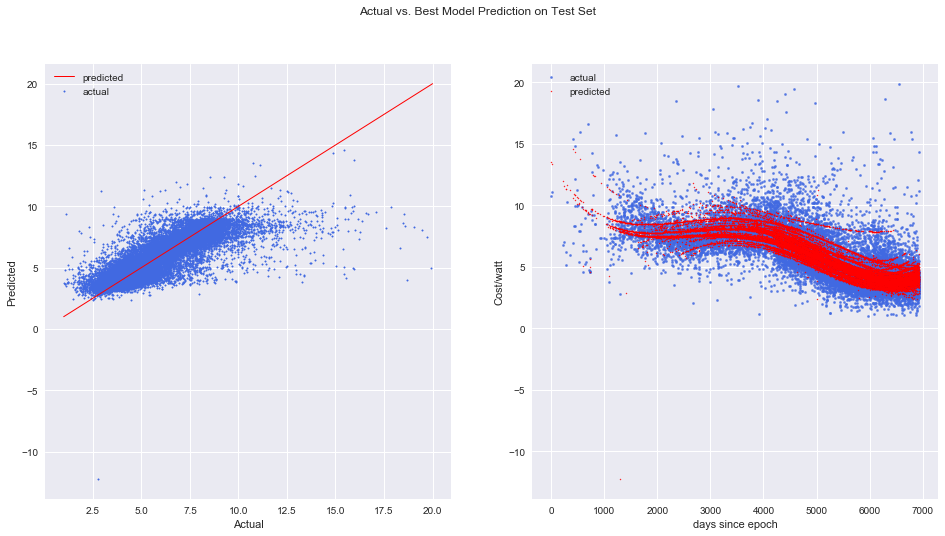

In [86]:
# # Show R2
# theR2 = gs_cv.score(X_test, y_test)
# print("Best parameters: {}".format(gs_cv.best_params_))
# print("Best R squared: {}".format(theR2))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# fig.suptitle('Actual vs. Best Model Prediction on Test Set')

# ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
# ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
# ax1.set_ylabel('Predicted')
# ax1.set_xlabel('Actual')
# ax1.legend()

# ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
# ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=5, alpha=.8, label='predicted')
# ax2.set_ylabel('Cost/watt')
# ax2.set_xlabel('days since epoch')
# ax2.legend()

# plt.show();

### results of last cell

Best parameters: {'poly__degree': 4}
Best R squared: 0.6878430532328907

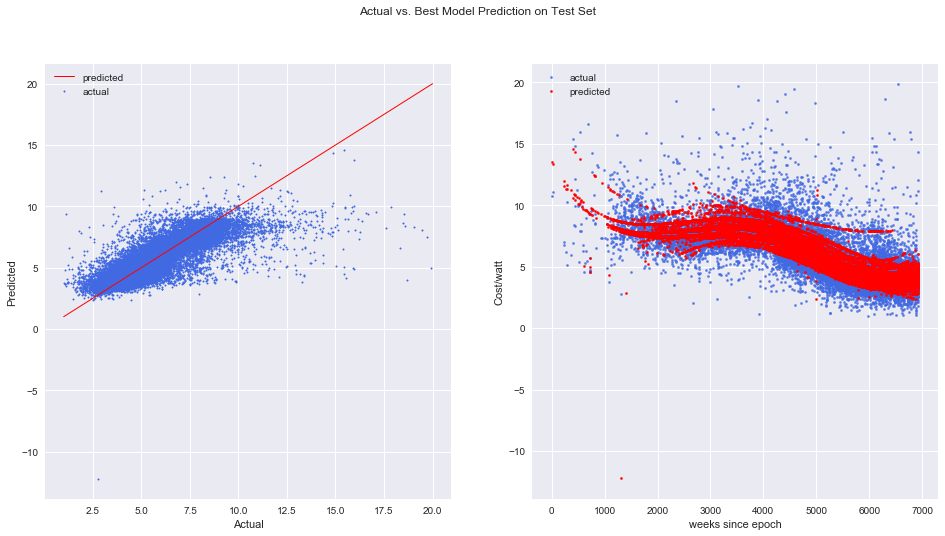

### Extrapolate with best model

#### Strategy for building X to extrapolate

Make a prediction X like in previous model.  

Just use 3 (maybe 5) states.   Then build a number_of(state cols) wide matrix with the same number of rows as X.  Then glue them together.

Or could do 3 (5) separate Xs done the same way.  That way the predictions could be plotted in different colors.

The good news is this can be reused when I redo this without poly expanding the states.


### just build california to start

#### Build an X with scaleSize 5

In [83]:
X[-1, :]

array([6.931e+03, 7.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00])

In [88]:
# number of days
x1 = np.linspace(0.0, 7550, int(7550/91)); x1.shape
x2 = np.zeros(82); x2[:] = 5.0
print(x1.shape, x2.shape)

(82,) (82,)


In [89]:
X_future = np.stack([x1, x2], axis=-1); X_future.shape

(82, 2)

In [92]:
state_CA = np.zeros((82, 18)); state_CA.shape

(82, 18)

In [94]:
state_CA[:, 1] = 1.0; state_CA[:5,:]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [103]:
X_CA = np.concatenate([X_future, state_CA], axis=1); thing.shape

(82, 20)

In [104]:
gs_cv.predict(X_CA).shape

(82, 1)

### Okay, that's the right shape; now build some others.

In [ ]:
# X_f5 = X_future
# X_f1 = X_future.copy()
# X_f1[:, 1] = 1.0

In [ ]:
# X_f9 = X_future.copy()
# X_f9[:, 1] = 9.0

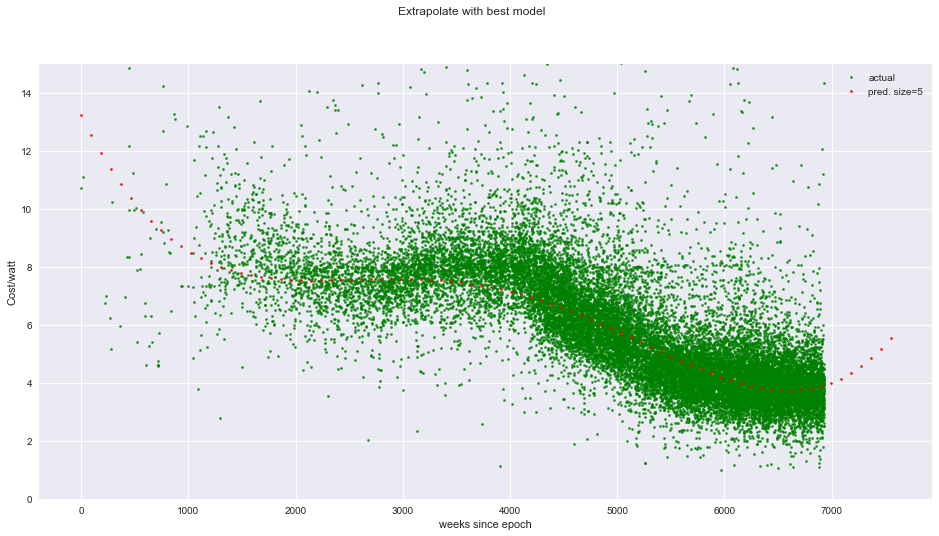

In [106]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')


ax.scatter(X_test[:,0], y_test, marker='.', color='green', s=20, alpha=0.9, label='actual')
ax.scatter(X_CA[:, 0].reshape(-1, 1), gs_cv.predict(thing), marker='.', color='red', s=20, alpha=1, label='pred. size=5')
# ax.scatter(X_f1[:, 0].reshape(-1, 1), gs_cv.predict(X_f1), marker='.', color='blue', s=20, alpha=1, label='pred. size=1')
# ax.scatter(X_f9[:, 0].reshape(-1, 1), gs_cv.predict(X_f9), marker='.', color='purple', s=20, alpha=1, label='pred. size=9')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('weeks since epoch')
ax.set_ylim(0,15)
ax.legend();

### predict month with 3rd degree model
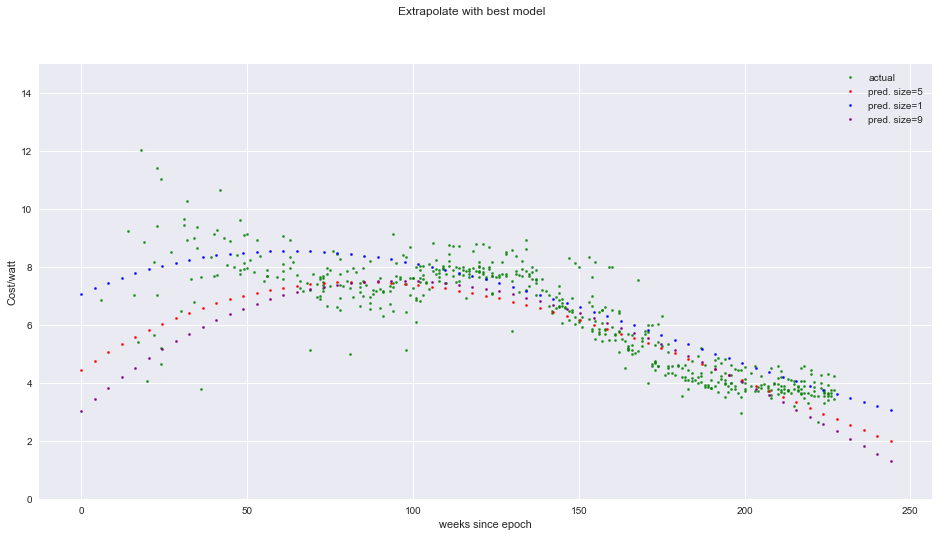

In [114]:
gs_cv.cv_results_['mean_test_RMSE']

array([-1.3305, -1.2452, -1.2013, -1.1862])

In [115]:
def trainVsTestResults(results): 
    ''' Plot test/train results for R^2 and RMSE'''    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean cross-validation train/test RMSE and R^2 vs poly degree'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(np.arange(1, n + 1), np.abs(mean_train_RMSE), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax1.plot(np.arange(1, n + 1), np.abs(mean_test_RMSE), marker='*', ms=10, alpha=1.0, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('polynomial degree')
    ax1.set_title('mean train/test RMSE vs poly degree')
    ax1.set_ylim(0, 1.5)
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_))

    ax2.plot(np.arange(1, n + 1), np.abs(mean_train_R2), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax2.plot(np.arange(1, n + 1), np.abs(mean_test_R2), marker='*', ms=10, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('polynomial degree')
    ax2.set_title('mean train/test R2 vs poly degree')
    ax2.set_ylim(0, 1)
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best parameters test R squared: {}".format(r2))

In [121]:
gs_cv.cv_results_

{'mean_fit_time': array([8.7901e-02, 7.3963e-01, 1.0870e+01, 5.3892e+02]),
 'std_fit_time': array([1.4468e-02, 3.6844e-02, 2.2101e-01, 2.2854e+01]),
 'mean_score_time': array([ 0.0287,  0.2413,  1.9104, 19.1073]),
 'std_score_time': array([0.0031, 0.0419, 0.0469, 1.3863]),
 'param_poly__degree': masked_array(data=[1, 2, 3, 4],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'poly__degree': 1},
  {'poly__degree': 2},
  {'poly__degree': 3},
  {'poly__degree': 4}],
 'split0_test_Rsquared': array([0.595 , 0.6401, 0.6673, 0.6452]),
 'split1_test_Rsquared': array([0.5722, 0.6283, 0.6508, 0.6754]),
 'split2_test_Rsquared': array([0.5859, 0.6393, 0.6654, 0.6872]),
 'mean_test_Rsquared': array([0.5844, 0.6359, 0.6612, 0.6693]),
 'std_test_Rsquared': array([0.0094, 0.0054, 0.0073, 0.0177]),
 'rank_test_Rsquared': array([4, 3, 2, 1]),
 'split0_train_Rsquared': array([0.5794, 0.6302, 0.6621, 0.6882]),
 'split1_train_Rsquared': array

Best parameters: {'poly__degree': 4}
Best parameters test R squared: 0.6878430532328907


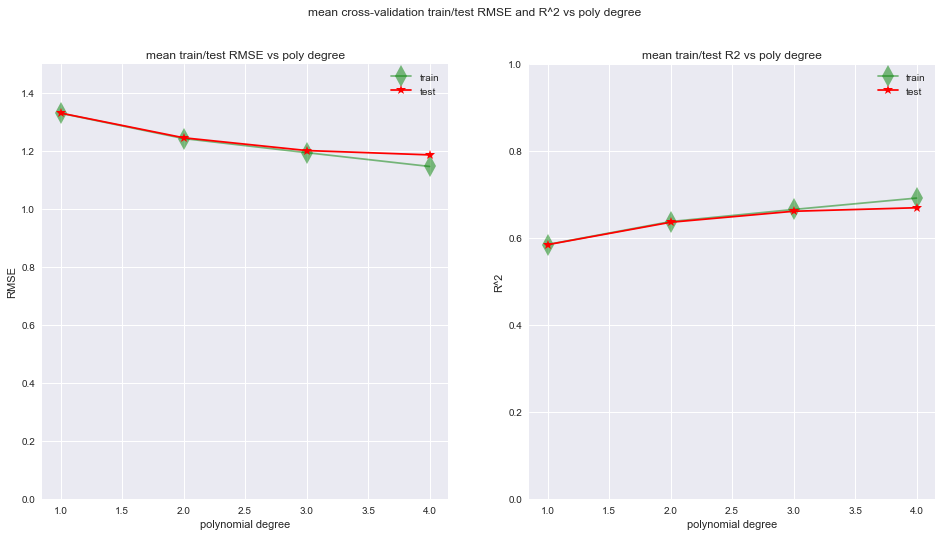

In [116]:
trainVsTestResults(gs_cv.cv_results_)

## this 3th degree model looks okay and predictions look okay, also.  

train/test results imply that I might buy better $R^2$ with high degree poly but clearly the slope has already leveled off at 3rd degree.  3rd degree $R^2$: 0.66; 4th-degree $R^2$: 0.69.

Before modeling at the week seemed good; it rejects more noise than days (because populations within a day can be as small as one; that's true of weeks too, but generally weeks have a better chance to let median work).

### now by week

In [126]:
by_week_size_state = dfMod.groupby(['num_weeks', 'scaleSize', 'state'])
med_by_week_size_state = by_week_size_state.cost_per_watt.median()
mean_by_week_size_state = by_week_size_state.cost_per_watt.mean()
print(med_by_week_size_state.head())
print()
print(mean_by_week_size_state.head())


num_weeks  scaleSize  state
0.0        0.0        CA       10.734315
3.0        0.0        CA       11.108701
4.0        0.0        CA        8.667013
12.0       0.0        CA       13.270286
16.0       0.0        CA       14.654839
Name: cost_per_watt, dtype: float64

num_weeks  scaleSize  state
0.0        0.0        CA       10.734315
3.0        0.0        CA       11.108701
4.0        0.0        CA        8.667013
12.0       0.0        CA       13.270286
16.0       0.0        CA       14.654839
Name: cost_per_watt, dtype: float64


In [127]:
### the Xs are in the index; the ys are vals
med_by_week_size_state.head()

num_weeks  scaleSize  state
0.0        0.0        CA       10.734315
3.0        0.0        CA       11.108701
4.0        0.0        CA        8.667013
12.0       0.0        CA       13.270286
16.0       0.0        CA       14.654839
Name: cost_per_watt, dtype: float64

In [128]:
### shove over so I can grab the pieces as columns
df_med_week_size_state = med_by_week_size_state.reset_index(); df_med_week_size_state.head()

,num_weeks,scaleSize,state,cost_per_watt
0,0.0,0.0,CA,10.734315
1,3.0,0.0,CA,11.108701
2,4.0,0.0,CA,8.667013
3,12.0,0.0,CA,13.270286
4,16.0,0.0,CA,14.654839


In [129]:
dfModWeek = pd.get_dummies(df_med_week_size_state, drop_first=True); dfModWeek.head()

,num_weeks,scaleSize,cost_per_watt,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
0,0.0,0.0,10.734315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.0,0.0,11.108701,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.0,0.0,8.667013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12.0,0.0,13.270286,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,16.0,0.0,14.654839,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [131]:
X = dfModWeek.drop(['cost_per_watt'], axis='columns').values
y = dfModWeek[['cost_per_watt']].values
X.shape, y.shape

((32548, 20), (32548, 1))

### nightmare slow...

In [134]:
# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 5)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared', verbose=True)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 29.3min finished


Best parameters: {'poly__degree': 3}
test R squared: 0.7068979728422194


In [135]:
gs_cv.cv_results_['mean_test_RMSE']

array([-1.319 , -1.1947, -1.1398, -1.1638])

Best parameters: {'poly__degree': 3}
Best R squared: 0.7068979728422194


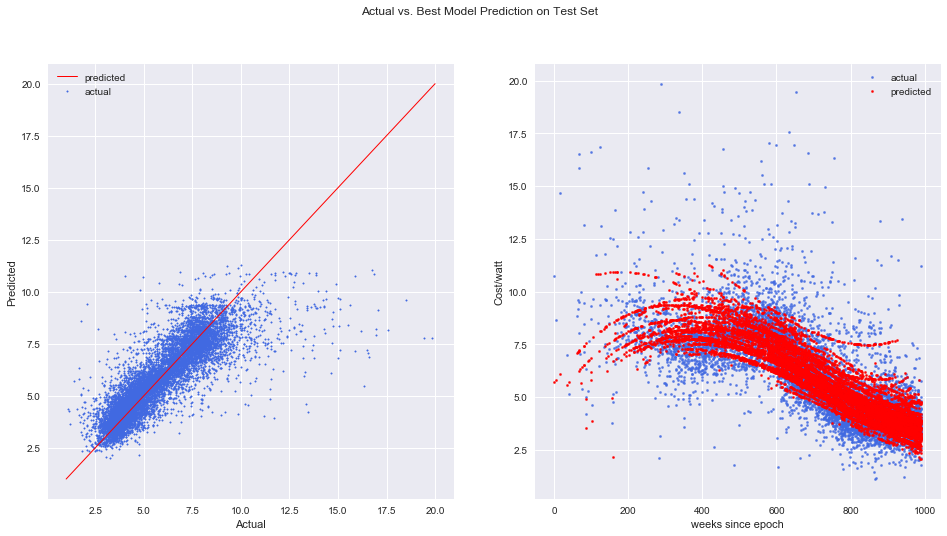

In [136]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=20, alpha=1, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('weeks since epoch')
ax2.legend()

plt.show();

### just build california to start

#### Build an X with scaleSize 5

In [138]:
# 990 weeks is the last one
X[-1, :]

array([990.,   9.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [140]:
# number of weeks
x1 = np.linspace(0.0, 1100, int(1100/12)); x1.shape
x2 = np.zeros(91); x2[:] = 5.0
print(x1.shape, x2.shape)

(91,) (91,)


In [141]:
X_future = np.stack([x1, x2], axis=-1); X_future.shape

(91, 2)

In [142]:
state_CA = np.zeros((91, 18)); state_CA.shape

(91, 18)

In [143]:
state_CA[:, 1] = 1.0; state_CA[:5,:]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [147]:
X_CA_s5 = np.concatenate([X_future, state_CA], axis=1)

In [148]:
X_CA_s5.shape

(91, 20)

In [149]:
gs_cv.predict(X_CA_s5).shape

(91, 1)

### make copies with size 1 and size 9

In [153]:
X_CA_s5[0, :]

array([0., 5., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [155]:
X_CA_s1 = X_CA_s5.copy()

In [156]:
X_CA_s1[:, 1] = 1

In [157]:
X_CA_s1[0, :]

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [158]:
X_CA_s9 = X_CA_s5.copy()

In [159]:
X_CA_s9[:, 1] = 9

In [161]:
X_CA_s9[0, :]

array([0., 9., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

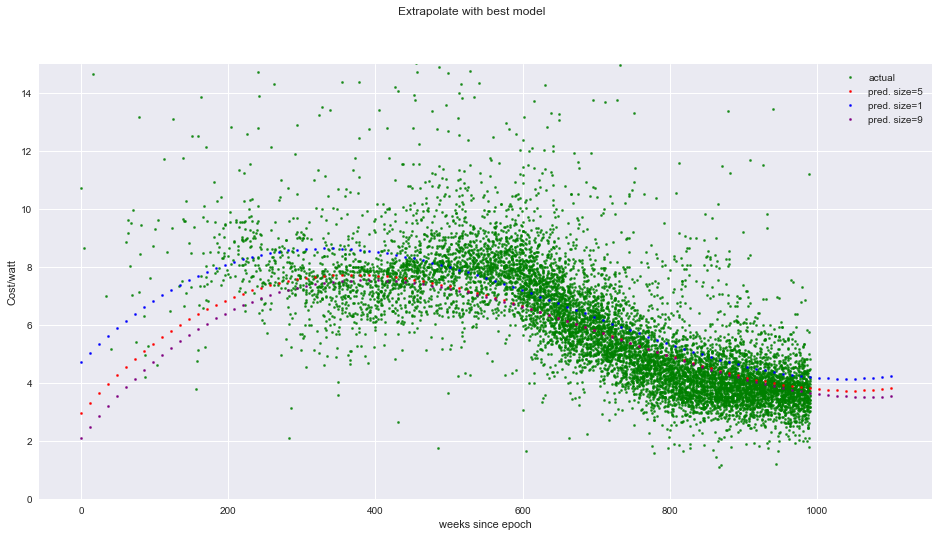

In [163]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')

ax.scatter(X_test[:,0], y_test, marker='.', color='green', s=20, alpha=0.9, label='actual')
ax.scatter(X_CA_s5[:, 0].reshape(-1, 1), gs_cv.predict(X_CA_s5), marker='.', color='red', s=20, alpha=1, label='pred. size=5')
ax.scatter(X_CA_s1[:, 0].reshape(-1, 1), gs_cv.predict(X_CA_s1), marker='.', color='blue', s=20, alpha=1, label='pred. size=1')
ax.scatter(X_CA_s9[:, 0].reshape(-1, 1), gs_cv.predict(X_CA_s9), marker='.', color='purple', s=20, alpha=1, label='pred. size=9')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('weeks since epoch')
ax.set_ylim(0,15)
ax.legend();

---

In [164]:
by_month_size_state = dfMod.groupby(['num_months', 'scaleSize', 'state'])
med_by_month_size_state = by_month_size_state.cost_per_watt.median()
mean_by_month_size_state = by_month_size_state.cost_per_watt.mean()
print(med_by_month_size_state.head())
print()
print(mean_by_month_size_state.head())


num_months  scaleSize  state
0.0         0.0        CA       10.921508
1.0         0.0        CA        8.667013
3.0         0.0        CA       13.962563
6.0         1.0        CA        6.858942
7.0         0.0        CA        6.768190
Name: cost_per_watt, dtype: float64

num_months  scaleSize  state
0.0         0.0        CA       10.921508
1.0         0.0        CA        8.667013
3.0         0.0        CA       13.962563
6.0         1.0        CA        6.858942
7.0         0.0        CA        6.768190
Name: cost_per_watt, dtype: float64


In [165]:
### the Xs are in the index; the ys are vals
med_by_month_size_state.head()

num_months  scaleSize  state
0.0         0.0        CA       10.921508
1.0         0.0        CA        8.667013
3.0         0.0        CA       13.962563
6.0         1.0        CA        6.858942
7.0         0.0        CA        6.768190
Name: cost_per_watt, dtype: float64

In [166]:
### shove over so I can grab the pieces as columns
df_med_month_size_state = med_by_month_size_state.reset_index(); df_med_month_size_state.head()

,num_months,scaleSize,state,cost_per_watt
0,0.0,0.0,CA,10.921508
1,1.0,0.0,CA,8.667013
2,3.0,0.0,CA,13.962563
3,6.0,1.0,CA,6.858942
4,7.0,0.0,CA,6.768190


In [167]:
dfModmonth = pd.get_dummies(df_med_month_size_state, drop_first=True); dfModmonth.head()

,num_months,scaleSize,cost_per_watt,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
0,0.0,0.0,10.921508,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,0.0,8.667013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,0.0,13.962563,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.0,1.0,6.858942,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7.0,0.0,6.768190,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [168]:
X = dfModmonth.drop(['cost_per_watt'], axis='columns').values
y = dfModmonth[['cost_per_watt']].values
X.shape, y.shape

((11684, 20), (11684, 1))

### nightmare slow...

In [172]:
# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 5)
param_grid = {'poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared', verbose=3)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] poly__degree=1 ..................................................
[CV]  poly__degree=1, Rsquared=0.6141723897729403, RMSE=-1.35494867788238, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV]  poly__degree=1, Rsquared=0.6206167027426541, RMSE=-1.3478691867386463, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV]  poly__degree=1, Rsquared=0.6341845743717887, RMSE=-1.298277435722456, total=   0.0s
[CV] poly__degree=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  poly__degree=2, Rsquared=0.7009664179468538, RMSE=-1.1928509358268966, total=   0.0s
[CV] poly__degree=2 ..................................................
[CV]  poly__degree=2, Rsquared=0.7125589441692601, RMSE=-1.1732296811318945, total=   0.0s
[CV] poly__degree=2 ..................................................
[CV]  poly__degree=2, Rsquared=0.7228525251625277, RMSE=-1.1300351815727574, total=   0.0s
[CV] poly__degree=3 ..................................................
[CV]  poly__degree=3, Rsquared=0.7307870809776852, RMSE=-1.1318116047100557, total=   2.9s
[CV] poly__degree=3 ..................................................
[CV]  poly__degree=3, Rsquared=0.7302463754370626, RMSE=-1.136559787351879, total=   3.5s
[CV] poly__degree=3 ..................................................
[CV]  poly__degree=3, Rsquared=0.7389360405861072, RMSE=-1.096755855838311, total=   2.7s
[CV] poly__degree=4 ..................................................
[CV]  poly__degree=4, Rsquared

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.2min finished


Best parameters: {'poly__degree': 3}
test R squared: 0.7348932746562986


In [173]:
gs_cv.cv_results_['mean_test_RMSE']

array([-1.3337, -1.1654, -1.1217, -3.0935])

Best parameters: {'poly__degree': 3}
Best R squared: 0.7348932746562986


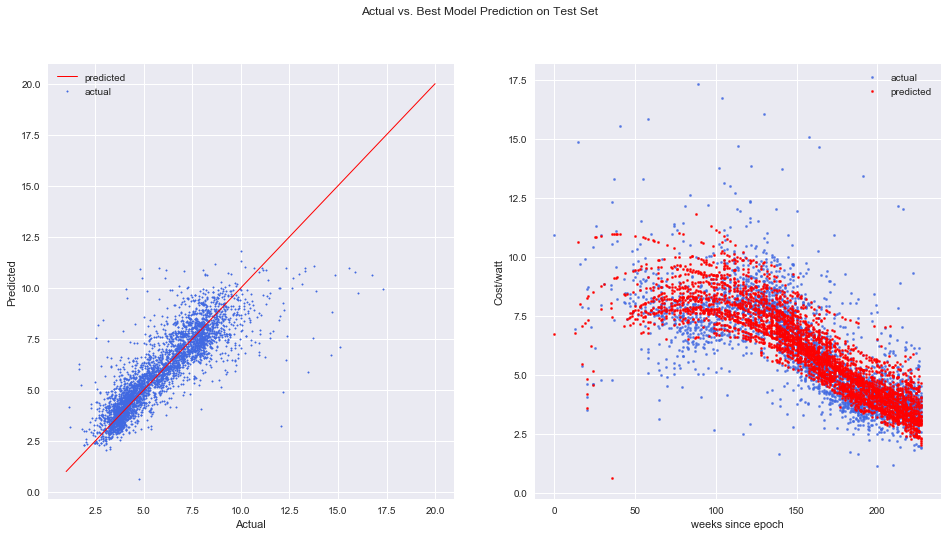

In [174]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test[:, 0], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test[:, 0], gs_cv.predict(X_test), marker='.', color='red', s=20, alpha=1, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('weeks since epoch')
ax2.legend()

plt.show();

### just build california to start

#### Build an X with scaleSize 5

In [175]:
# 227 weeks is the last one
X[-1, :]

array([227.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.])

In [198]:
### number of weeks
x1 = np.linspace(0.0, 252, int(252/4)); x1.shape
x2 = np.zeros(63); x2[:] = 5.0
print(x1.shape, x2.shape)

(63,) (63,)


In [199]:
X_future = np.stack([x1, x2], axis=-1); X_future.shape

(63, 2)

In [201]:
state_CA = np.zeros((63, 18)); state_CA.shape

(63, 18)

In [202]:
state_CA[:, 1] = 1.0; state_CA[:5,:]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [203]:
X_CA_s5 = np.concatenate([X_future, state_CA], axis=1)

In [204]:
X_CA_s5.shape

(63, 20)

In [205]:
gs_cv.predict(X_CA_s5).shape

(63, 1)

### make copies with size 1 and size 9

In [206]:
X_CA_s5[0, :]

array([0., 5., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [207]:
X_CA_s1 = X_CA_s5.copy()

In [208]:
X_CA_s1[:, 1] = 1

In [209]:
X_CA_s1[0, :]

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [210]:
X_CA_s9 = X_CA_s5.copy()

In [211]:
X_CA_s9[:, 1] = 9

In [212]:
X_CA_s9[0, :]

array([0., 9., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

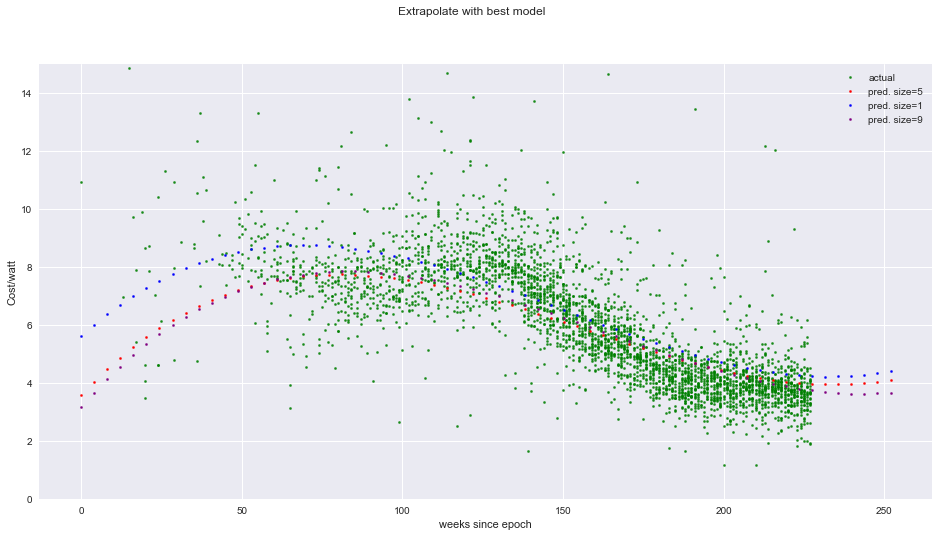

In [213]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model')

ax.scatter(X_test[:,0], y_test, marker='.', color='green', s=20, alpha=0.9, label='actual')
ax.scatter(X_CA_s5[:, 0].reshape(-1, 1), gs_cv.predict(X_CA_s5), marker='.', color='red', s=20, alpha=1, label='pred. size=5')
ax.scatter(X_CA_s1[:, 0].reshape(-1, 1), gs_cv.predict(X_CA_s1), marker='.', color='blue', s=20, alpha=1, label='pred. size=1')
ax.scatter(X_CA_s9[:, 0].reshape(-1, 1), gs_cv.predict(X_CA_s9), marker='.', color='purple', s=20, alpha=1, label='pred. size=9')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('weeks since epoch')
ax.set_ylim(0,15)
ax.legend();

---